In [137]:
import pandas as pd
import numpy as np
df = pd.read_csv("../../data/preprocessed/health-social-determinants-clustering/health_social_determinants.csv",sep=";")
df.head().columns

Index(['code', 'deces_domicilies_2024', 'part_75_ans_plus', 'taux_pauvrete',
       'revenu_median', 'part_sans_diplome', 'part_ouvriers',
       'part_familles_monoparentales', 'part_moins_15_ans', 'taille_menage',
       'part_locataires', 'part_locataires_HLM', 'part_suroccupation',
       'part_residences_principales', 'part_appartements', 'part_maisons',
       'densite_population', 'part_benef_ophtalmo', 'apl_generaliste',
       'densite_orthophonistes', 'densite_generalistes', 'densite_infirmiers',
       'densite_sages_femmes', 'part_benef_ald', 'densite_pharmacies',
       'libelle'],
      dtype='object')

### 🔄 Préparation des données pour le clustering

Avant de pouvoir regrouper les territoires (bassins de vie) selon leurs caractéristiques sociales et sanitaires, on doit **nettoyer et transformer les données**.

1. On enlève les colonnes inutiles pour le clustering, comme les codes ou noms de commune.
2. On supprime les lignes incomplètes (avec des valeurs manquantes).
3. On standardise les données (centrage et réduction), pour que toutes les variables soient sur la même échelle.
4. On enlève aussi les outliers extrêmes (valeurs très anormales), qui peuvent fortement perturber les regroupements.

Ce traitement est important, car les méthodes de clustering utilisent des **distances** : il ne faut donc pas qu’une variable "pèse" plus qu’une autre à cause de son unité, ou qu’un point très éloigné déforme l’ensemble de l’analyse.


In [138]:
from sklearn.discriminant_analysis import StandardScaler

columns_to_drop= ["code", "libelle","part_benef_ald"]
df_features = df.drop(columns=columns_to_drop)

df_clean = df_features.dropna()

print(f"{len(df_features) - len(df_clean)} lignes supprimées à cause de NaN.")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)
X_scaled


11 lignes supprimées à cause de NaN.


array([[ 0.02707733, -0.96122523, -0.43622442, ..., -0.04327731,
         0.32533735, -0.68928196],
       [-0.08368409, -1.27405   , -0.06262289, ..., -1.14633402,
         0.27058112, -0.68928196],
       [-0.03490315,  0.03981406, -0.16093908, ...,  0.39557321,
        -0.38649366,  0.06769933],
       ...,
       [ 0.03224237, -1.96226451,  5.89533842, ...,  0.63278971,
         0.70863097, -0.50003663],
       [ 0.4454456 , -1.99354699,  3.61440274, ...,  0.41929486,
         0.98241212, -0.12154599],
       [ 0.49307874, -1.86841708,  4.40093229, ...,  1.1072227 ,
         0.48960604, -0.50003663]], shape=(1694, 23))

### 📊 Étape 1 : Clustering des territoires

L’objectif est de regrouper les bassins de vie selon leurs caractéristiques sociales et sanitaires.  
On utilise l’algorithme de **K-Means**, qui permet de créer des groupes d’observations similaires.

Le nombre de groupes (`k`) est choisi arbitrairement au début (par exemple 4), mais on pourra l’ajuster ensuite.  
Chaque groupe correspond à un type de territoire, avec des profils proches (par exemple : zones jeunes et riches, zones âgées et pauvres, etc.).

On utilisera plus tard une **PCA** pour **visualiser ces groupes** sur un plan 2D.


In [139]:
from sklearn.cluster import KMeans

# Choix du nombre de clusters
k = 4

kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(X_scaled)

df_clean["cluster"] = labels

print(df_clean["cluster"].value_counts().sort_index())

df_clustered = df.loc[df_clean.index].copy()
df_clustered["cluster"] = labels


cluster
0    591
1    225
2    276
3    602
Name: count, dtype: int64


/tmp/ipykernel_459813/4118491077.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["cluster"] = labels


### 🎯 Étape 2 : Visualisation des clusters avec la PCA

Maintenant qu’on a créé des groupes de territoires (clusters), on aimerait les **visualiser**.  
Comme nos données ont beaucoup de variables (âge, pauvreté, logement, etc.), on ne peut pas les afficher directement.

On utilise donc une **PCA** (Analyse en Composantes Principales) :  
elle permet de **réduire les données à 2 dimensions** tout en gardant le plus d’information possible.

On affiche ensuite chaque territoire sur un graphique 2D, coloré selon son groupe.  
Cela permet de **voir si les clusters sont bien séparés** ou mélangés.

/tmp/ipykernel_459813/725937788.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["pca_1"] = X_pca[:, 0]
/tmp/ipykernel_459813/725937788.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["pca_2"] = X_pca[:, 1]


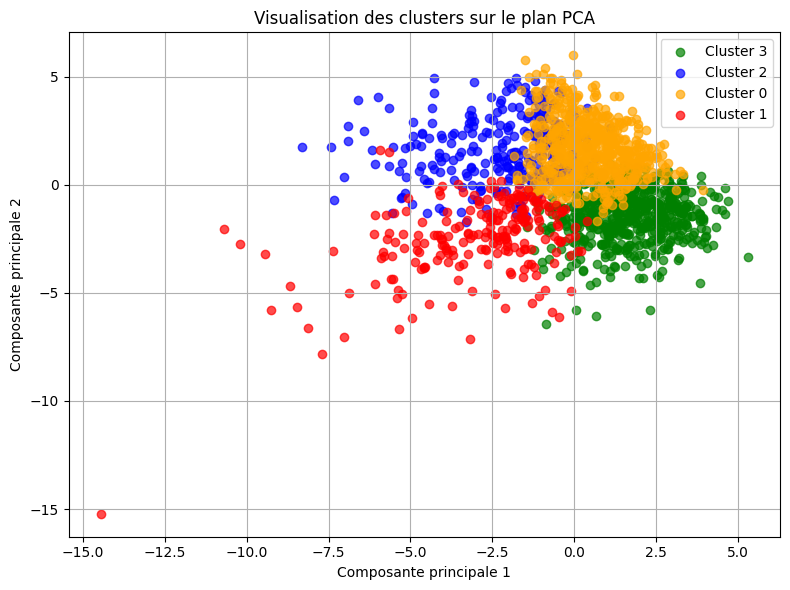

In [140]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_clean["pca_1"] = X_pca[:, 0]
df_clean["pca_2"] = X_pca[:, 1]

couleurs_clusters = {
    3: "green",   
    2: "blue",    
    0: "orange",   
    1: "red",      
}

plt.figure(figsize=(8, 6))

for cluster_id, couleur in couleurs_clusters.items():
    cluster_data = df_clean[df_clean["cluster"] == cluster_id]
    plt.scatter(
        cluster_data["pca_1"],
        cluster_data["pca_2"],
        label=f"Cluster {cluster_id}",
        color=couleur,
        alpha=0.7,
    )

plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("Visualisation des clusters sur le plan PCA")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Pour comprendre ce que représentent les deux axes de l’ACP, on regarde les variables qui y contribuent le plus.
Cela nous permet de dire, par exemple, que l’axe 1 reflète surtout le niveau de vie ou la densité, etc.

In [141]:
feature_names = df.columns.drop(columns_to_drop, errors="ignore")
components = pca.components_  
loadings = pd.DataFrame(components.T, index=feature_names, columns=["PC1", "PC2"])


relative_importance_PC1 = (loadings["PC1"] ** 2) / np.sum(loadings["PC1"] ** 2)
relative_importance_PC2 = (loadings["PC2"] ** 2) / np.sum(loadings["PC2"] ** 2)

print("Top variables (en proportion) sur PC1 :")
print((relative_importance_PC1.sort_values(ascending=False).head(10) * 100).round(2))
print
print("Top variables (en proportion) sur PC2 :")
print((relative_importance_PC2.sort_values(ascending=False).head(10) * 100).round(2))


Top variables (en proportion) sur PC1 :
part_maisons                    11.29
part_appartements               11.16
part_locataires                  9.51
part_familles_monoparentales     8.16
taux_pauvrete                    6.86
taille_menage                    6.40
densite_pharmacies               5.14
apl_generaliste                  4.71
part_ouvriers                    4.65
part_suroccupation               4.38
Name: PC1, dtype: float64
Top variables (en proportion) sur PC2 :
part_75_ans_plus               14.64
part_moins_15_ans              12.45
taille_menage                   9.13
part_residences_principales     7.21
densite_population              7.08
revenu_median                   6.41
part_locataires_HLM             4.93
densite_pharmacies              4.80
part_sans_diplome               4.30
part_locataires                 4.22
Name: PC2, dtype: float64


Les deux premières composantes principales nous permettent de mieux comprendre les différences entre territoires :

PC1 oppose les territoires plus précaires, denses et locataires à ceux plus pavillonnaires, familiaux, et plutôt stables socialement.

PC2 oppose les zones jeunes ou denses, parfois à forte précarité, à des zones plus âgées, moins denses et économiquement plus stables.

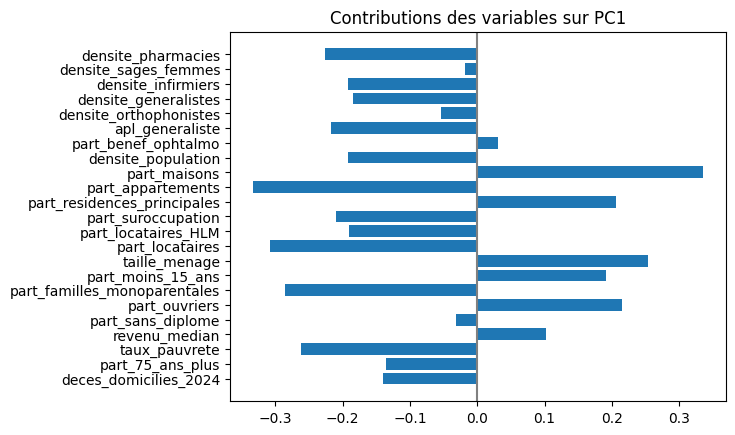

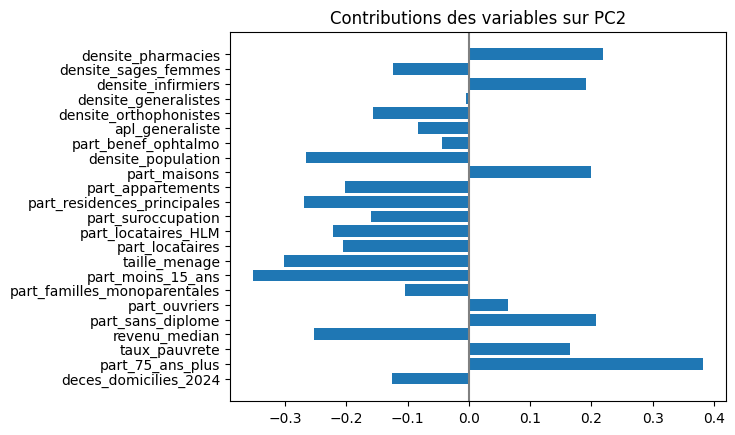

In [142]:
plt.barh(range(len(loadings["PC1"])), loadings["PC1"])
plt.yticks(range(len(feature_names)), feature_names)
plt.title("Contributions des variables sur PC1")
plt.axvline(0, color="gray")
plt.show()

plt.barh(range(len(loadings["PC2"])), loadings["PC2"])
plt.yticks(range(len(feature_names)), feature_names)
plt.title("Contributions des variables sur PC2")
plt.axvline(0, color="gray")
plt.show()


### 🧠 Lecture des axes PCA

* **PC1** oppose les **logiques résidentielles** :
  ➕ à droite : territoires avec beaucoup de **maisons**, **peu d’HLM**, **moins de pauvreté**
  ➖ à gauche : zones avec plus de **locataires**, **HLM**, **pauvreté**, **familles monoparentales**
  👉 Cet axe reflète donc un **gradient de précarité résidentielle**.

* **PC2** distingue la **structure démographique** :
  ➕ en haut : territoires avec plus de **personnes âgées**
  ➖ en bas : territoires plus **jeunes** (plus d’enfants, plus de ménages nombreux)


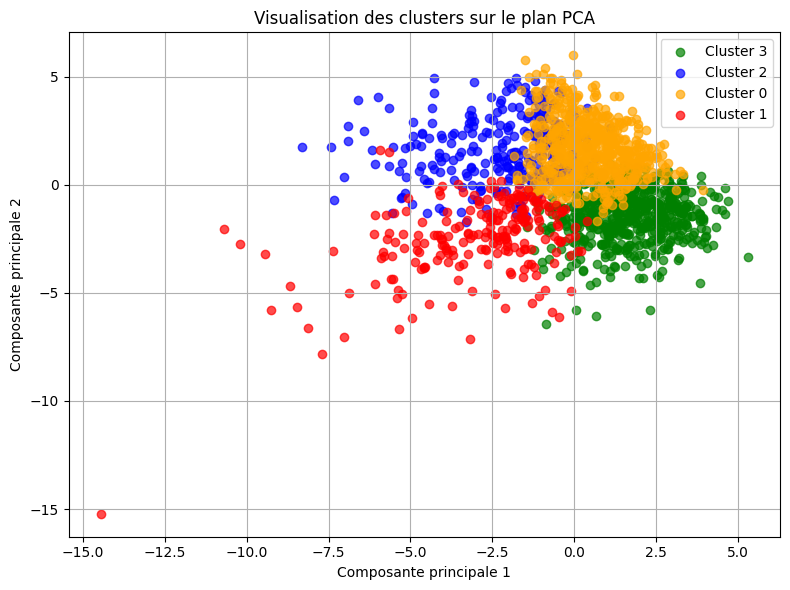

In [143]:
couleurs_clusters = {
    3: "green",   
    2: "blue",    
    0: "orange",   
    1: "red",      
}

plt.figure(figsize=(8, 6))

for cluster_id, couleur in couleurs_clusters.items():
    cluster_data = df_clean[df_clean["cluster"] == cluster_id]
    plt.scatter(
        cluster_data["pca_1"],
        cluster_data["pca_2"],
        label=f"Cluster {cluster_id}",
        color=couleur,
        alpha=0.7,
    )

plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("Visualisation des clusters sur le plan PCA")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 🧭 Ce que montre ce graphique

* Il s’agit d’une **projection en 2D** de données multidimensionnelles, à l’aide de l’**Analyse en Composantes Principales (ACP)**.
* Chaque **point** représente un **bassin de vie**.
* Les points sont colorés selon leur **cluster**, c’est-à-dire le groupe auquel ils appartiennent selon leurs caractéristiques **sociales et sanitaires**.
* Les **axes PCA 1 et PCA 2** sont des synthèses des variables initiales (voir plus haut pour leur interprétation).

---

### 🔍 Comment lire le graphique

#### 1. **Répartition des clusters**

* On observe **4 groupes principaux** :

  * 🟩 **Cluster 3 (vert)** : territoires plutôt **favorisés**, bien regroupés dans la zone droite du graphique.
  * 🔵 **Cluster 2 (bleu)** : profils **intermédiaires**, un peu plus dispersés au centre-gauche.
  * 🟠 **Cluster 0 (orange)** : zones **rurales ou populaires**, densément regroupées en haut à droite.
  * 🔴 **Cluster 1 (rouge)** : bassins de vie **précaires**, nettement isolés sur la gauche (profil très spécifique).

#### 2. **Interprétation des axes**

* L’axe **PC1 (horizontal)** traduit principalement des **différences sociales et de logement** (ex. précarité, type d’habitat).

  * Il oppose des territoires **plus aisés et résidentiels** (droite) à des territoires **plus précaires et denses** (gauche).
  * Les **indicateurs de densité médicale** (APL, médecins, infirmiers, pharmacies…) sont **plutôt positionnés à gauche**, ce qui peut surprendre :
    👉 Cela reflète le fait que **les zones socialement plus fragiles sont parfois mieux dotées en offre de soins**, peut-être du fait de politiques publiques compensatoires.

* L’axe **PC2 (vertical)** est lié à des facteurs **démographiques** :

  * En haut, des territoires **plus âgés** (forte part de +75 ans)
  * En bas, des territoires **plus jeunes** (forte part de –15 ans)

#### 3. **Les outliers (points isolés)**

* Certains points, notamment dans le **cluster 1 (rouge)**, sont **très éloignés du nuage principal** → ce sont des territoires avec des profils **très atypiques**, souvent cumulant plusieurs vulnérabilités.

---

### ✅ Conclusion

* Ce graphique illustre clairement que les **territoires les plus préoccupants** au regard des données sociales et sanitaires sont ceux du **cluster 1 (rouge)**.
* Les **territoires les plus favorisés** sont regroupés dans le **cluster 3 (vert)**.
* L’ACP confirme la **bonne séparation** entre les groupes identifiés par le clustering.
* Et surtout, elle révèle un point important :
  👉 **L’offre de soins n’est pas toujours là où les habitants sont les plus favorisés**, ce qui mérite d’être étudié de près dans une logique de **justice territoriale en santé**.

### 🧩 Une piste pour aller plus loin

Cette analyse croise **les caractéristiques sociales des territoires** et **l’offre de soins disponible**.
Mais pour compléter cette lecture, on pourrait ajouter une **troisième dimension essentielle** :
👉 l’**état de santé réel** des habitants (maladies chroniques, espérance de vie, ALD, obésité...).

Cela permettrait d’identifier les **territoires où les besoins en santé sont élevés** mais où l’**accès aux soins reste limité**, en mettant en lumière le **décalage entre forte demande et faible couverture**.
Une piste clé pour penser une **véritable justice territoriale en santé**.



-----

### 🧠 Analyse des profils par cluster

L’analyse en composantes principales nous a permis de **visualiser les grandes tendances et oppositions** entre territoires (logement, âge, densité, etc.).

Maintenant que les territoires sont regroupés en 4 clusters, on cherche à **comprendre ce qui caractérise chaque groupe**.

On va donc calculer la **moyenne de chaque variable** (pauvreté, revenu, âge, logement, etc.) pour chaque cluster.
Cela permet de voir quels types de territoires sont dans chaque groupe : par exemple, zones rurales âgées, zones urbaines jeunes, etc.

L’objectif est de **donner un profil** à chaque cluster.

In [144]:
variables_utiles = df_clean.drop(columns=["pca_1", "pca_2"]) 

cluster_profiles = variables_utiles.groupby("cluster").mean()

cluster_profiles = cluster_profiles.round(2)

from IPython.display import display

pd.set_option("display.max_columns", None)  
display(cluster_profiles)


,deces_domicilies_2024,part_75_ans_plus,taux_pauvrete,revenu_median,part_sans_diplome,part_ouvriers,part_familles_monoparentales,part_moins_15_ans,taille_menage,part_locataires,part_locataires_HLM,part_suroccupation,part_residences_principales,part_appartements,part_maisons,densite_population,part_benef_ophtalmo,apl_generaliste,densite_orthophonistes,densite_generalistes,densite_infirmiers,densite_sages_femmes,densite_pharmacies
cluster,,,,,,,,,,,,,,,,,,,,,,,
0,216.07,13.21,15.32,21324.94,25.04,28.51,13.39,15.41,2.10,26.17,7.11,0.25,77.48,13.32,85.84,49.86,26.42,2.87,17.53,6.40,17.48,1.47,3.22
1,1498.35,9.65,17.53,22440.76,21.73,21.84,18.72,17.76,2.17,42.06,17.67,0.67,85.99,43.66,55.50,383.96,27.11,3.79,33.02,7.97,16.52,2.38,3.03
2,244.58,14.67,15.09,22353.37,18.91,19.76,14.51,13.54,2.00,28.67,6.36,0.29,57.09,29.72,69.06,95.58,30.42,4.00,34.42,10.71,26.77,2.43,4.00
3,170.45,8.99,8.97,24428.95,17.76,25.90,12.56,18.73,2.32,25.03,6.94,0.25,87.50,16.97,82.25,129.29,29.71,3.26,35.01,7.66,14.10,2.76,2.39


## 🧠 Profil des clusters

Voici une description simple des 4 groupes de territoires identifiés :

---

#### 🟠 Cluster 0 — Zones rurales ou périurbaines âgées et populaires

* **APL** faible (2.87)
* **Population âgée** (13.2 % ont 75+ ans)
* **Densité faible** (env. 50 hab./km²)
* **Pauvreté élevée** (15.3 %), **revenu médian bas** (21 325 €)
* Taux très élevé d’**ouvriers** (28.5 %) et de **peu diplômés** (25 %)
* Habitats très majoritairement **en maisons** (85 %)

✅ Territoires **ruraux ou périurbains**, avec une population **vieillissante et modeste**, et un **accès limité à l’offre de soins**.

---

#### 🔴 Cluster 1 — Zones populaires denses et très fragiles

* **APL** plutôt élevé (3.79) malgré **forte densité** (384 hab./km²)
* Taux élevé d’**ouvriers** (21.8 %) et de **peu diplômés** (21.7 %)
* **Pauvreté forte** (17.5 %), **revenu modeste**
* Taux élevé de **locataires HLM**, de **suroccupation** et de **familles monoparentales**

✅ Profils de **zones urbaines populaires**, marquées par une **forte fragilité sociale**, mais paradoxalement **plutôt bien dotées en médecins**.

---

#### 🔵 Cluster 2 — Territoires urbains mixtes, familles monoparentales

* **APL** élevé (4.00)
* **Densité modérée** (96 hab./km²)
* Mix entre **appartements (30 %)** et **maisons (69 %)**
* **Pauvreté modérée** (15 %), **revenu médian** (22 350 €)
* Taux moyen de **familles monoparentales**, de **jeunes**, et de **bénéficiaires santé**

✅ Zones **mixtes et urbaines**, avec un **équilibre social moyen** mais une **bonne accessibilité médicale**.

---

#### 🟢 Cluster 3 — Zones résidentielles jeunes et favorisées

* **APL** modéré (3.26)
* **Pauvreté faible** (8.97 %), **revenu médian élevé** (24 429 €)
* Population **jeune** (18.7 % ont moins de 15 ans, seulement 9 % de 75+ ans)
* Forte part de **maisons (82 %)**, **densité modérée** (129 hab./km²)

✅ Territoires **résidentiels et plutôt aisés**, **moins fragiles socialement**, mais **pas les mieux desservis** par l’offre de soins. À nuancer, car ces zones présentent moins de besoins sanitaires apparents (population plus jeune, moins précaire).


### 🗺️ Cartographie des clusters par bassin de vie

Pour mieux visualiser les groupes de territoires, on crée une carte des bassins de vie colorés selon leur cluster.

Chaque couleur correspond à un profil de territoire (rural âgé, urbain dense, résidentiel favorisé, etc.). Cela permet d’**identifier les zones à risque ou prioritaires** pour des politiques de santé.

/tmp/ipykernel_459813/1044901822.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_merged.geometry.centroid.y.between(41.0, 51.5) &
/tmp/ipykernel_459813/1044901822.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_merged.geometry.centroid.x.between(-5.5, 10.0)


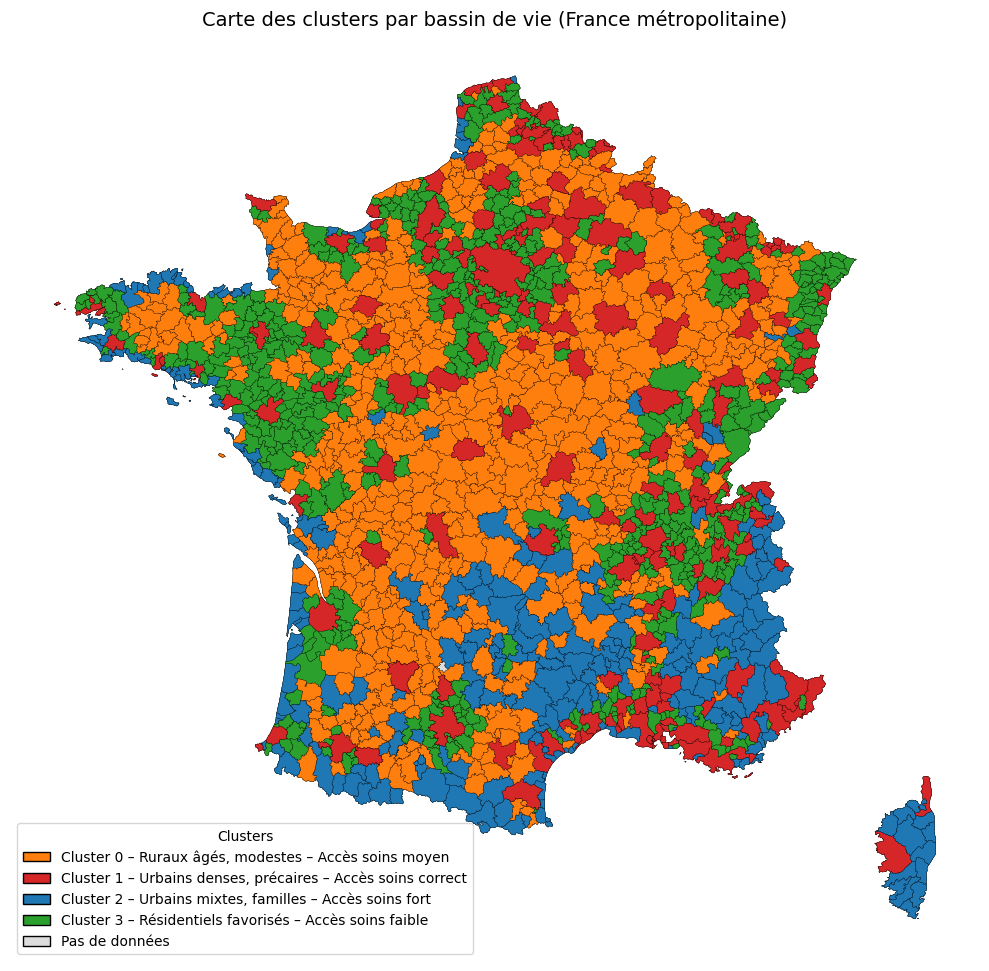

In [145]:
import geopandas as gpd
from shapely.geometry import shape
import json

df_clustered["code"] = df_clustered["code"].astype(str)

df_bassins_de_vie = pd.read_csv("../../data/contours/contour_bassins_de_vie.csv", sep=";")
df_bassins_de_vie["geometry"] = df_bassins_de_vie["Geo Shape"].apply(lambda geo: shape(json.loads(geo)) if pd.notnull(geo) else None)
df_bassins_de_vie = df_bassins_de_vie[df_bassins_de_vie["geometry"].notnull()]
df_bassins_de_vie["Code Officiel Bassin vie 2022"] = df_bassins_de_vie["Code Officiel Bassin vie 2022"].astype(str)

geo_df_bassins_de_vie = gpd.GeoDataFrame(df_bassins_de_vie, geometry="geometry", crs="EPSG:4326")

gdf_merged = geo_df_bassins_de_vie.merge(df_clustered[["code", "cluster"]], 
                           left_on="Code Officiel Bassin vie 2022", 
                           right_on="code", how="left")

gdf_merged = gdf_merged[
    gdf_merged.geometry.centroid.y.between(41.0, 51.5) &
    gdf_merged.geometry.centroid.x.between(-5.5, 10.0)
].copy()

cluster_colors = {
    0: "#ff7f0e",  
    1: "#d62728",  
    2: "#1f77b4",  
    3: "#2ca02c",  
}

gdf_merged["color"] = gdf_merged["cluster"].map(cluster_colors)
gdf_merged["color"] = gdf_merged["color"].fillna("#dddddd") 

fig, ax = plt.subplots(figsize=(10, 12))
gdf_merged.plot(color=gdf_merged["color"], edgecolor="black", linewidth=0.2, ax=ax)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="#ff7f0e", edgecolor="black", label="Cluster 0 – Ruraux âgés, modestes – Accès soins moyen"),
    Patch(facecolor="#d62728", edgecolor="black", label="Cluster 1 – Urbains denses, précaires – Accès soins correct"),
    Patch(facecolor="#1f77b4", edgecolor="black", label="Cluster 2 – Urbains mixtes, familles – Accès soins fort"),
    Patch(facecolor="#2ca02c", edgecolor="black", label="Cluster 3 – Résidentiels favorisés – Accès soins faible"),
    Patch(facecolor="#dddddd", edgecolor="black", label="Pas de données")
]


ax.legend(handles=legend_elements, title="Clusters", loc="lower left")
ax.set_title("Carte des clusters par bassin de vie (France métropolitaine)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()
